# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Displaying first 5 rows of data
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Displaying number of rows and columns
rows = azdias.shape[0]
columns = azdias.shape[1]

print('Rows:', rows, '\nColumns:', columns)

Rows: 891221 
Columns: 85


In [5]:
# Display statistics of database
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
# Display information on database
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values
num_missing = feat_info.isnull().count()[3]
print('Number of missing or unknown data value types:', num_missing)

Number of missing or unknown data value types: 85


In [8]:
# Checking how much data is naturally missing
natural_missing = azdias.isnull().sum().sum()
print('Number of missing data values in dataset:', natural_missing)

Number of missing data values in dataset: 4896838


In [9]:
# Convert missing or unknown data values to NaN
all_missing_values = []

for lis in feat_info['missing_or_unknown']:
    missing_values = []
    lis = lis.strip('[')
    lis = lis.strip(']')
    lis = lis.split(',')
    if lis != ['']:
        for value in lis:
            if value != 'X' and value != 'XX':
                missing_values.append(int(value))
            else:
                missing_values.append(value)
    else:
        missing_values.append('')
    all_missing_values.append(missing_values)
        
feat_info['na_values'] = all_missing_values
new_feat_info = feat_info.set_index('attribute')

for (index, attribute) in enumerate(azdias):
    azdias[attribute].replace(feat_info.loc[index].loc['na_values'], np.nan, inplace = True)

In [10]:
# Checking the number of updated missing values
natural_missing = azdias.isnull().sum().sum()
print('Number of updated missing values in dataset:', natural_missing)

Number of updated missing values in dataset: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

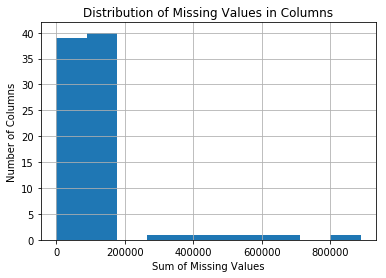

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Graphing the distribution of missing values
ascending_columns = azdias.isna().sum().sort_values(ascending=True)
ascending_columns.hist()
plt.title('Distribution of Missing Values in Columns')
plt.xlabel('Sum of Missing Values')
plt.ylabel('Number of Columns');

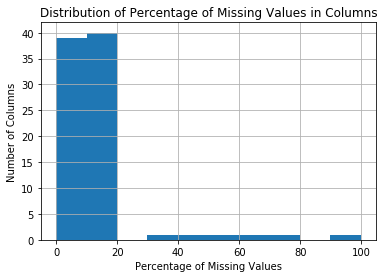

In [12]:
# Graphing percentage of missing values in columns
percentage_missing = (azdias.isna().sum() / azdias.shape[0]) * 100

percentage_missing.hist()
plt.title('Distribution of Percentage of Missing Values in Columns')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns');

In [13]:
# Displaying columns with highest sums of missing data in descending order

azdias.isna().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

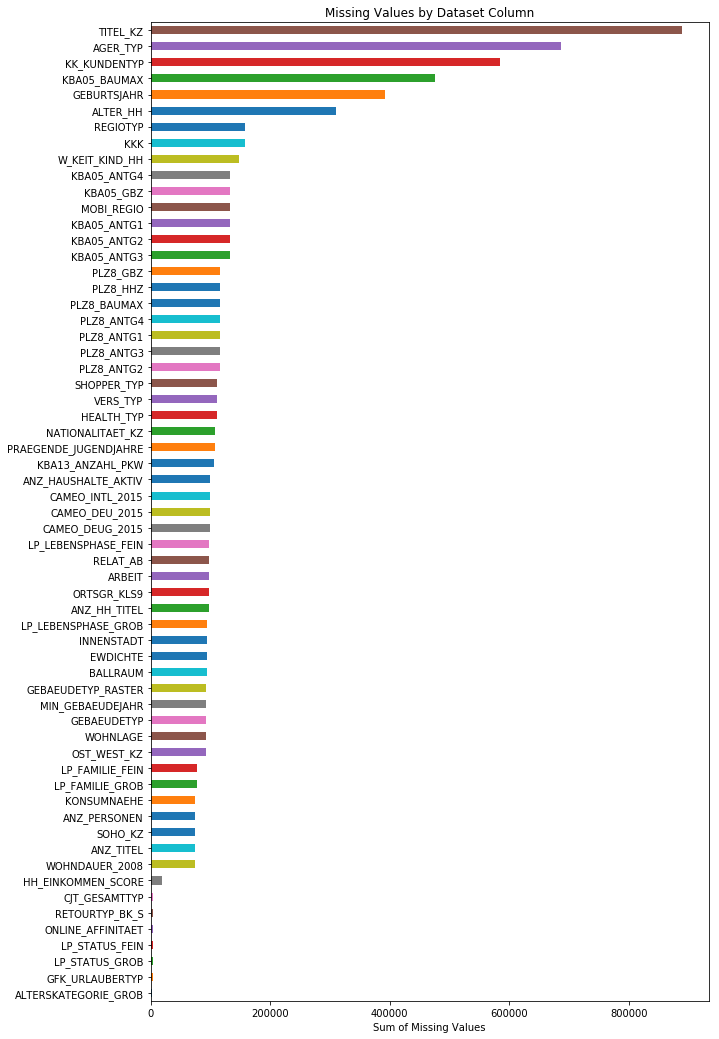

In [14]:
# Displaying graph of columns with the most missing data in descending order

missing_graph = ascending_columns[ascending_columns>0].plot(kind='barh', figsize = (10, 18))
missing_graph.set_xlabel('Sum of Missing Values')
missing_graph.set_title('Missing Values by Dataset Column');

In [15]:
# Investigate patterns in the amount of missing data in each column.
no_missing = (azdias.isna().sum() == 0).sum()
print('Number of columns with 0 missing values:', no_missing)

Number of columns with 0 missing values: 24


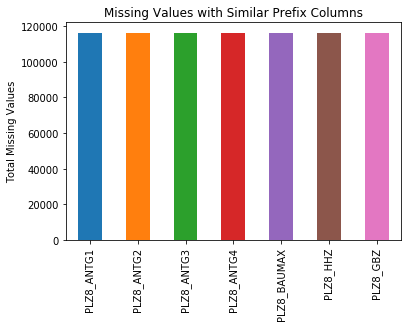

In [16]:
# Investigating columns with similar prefixes

plz8_cols = (azdias.loc[:, azdias.columns.str.startswith('PLZ8')]).isna().sum()
plz8_cols.plot(kind='bar')
plt.title('Missing Values with Similar Prefix Columns')
plt.ylabel('Total Missing Values');

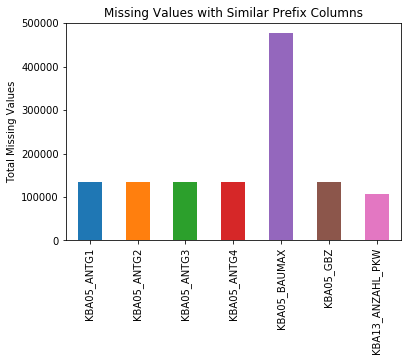

In [17]:
# Investigating columns with similar prefixes

kba_cols = (azdias.loc[:, azdias.columns.str.startswith('KBA')]).isna().sum()
kba_cols.plot(kind='bar')
plt.title('Missing Values with Similar Prefix Columns')
plt.ylabel('Total Missing Values');

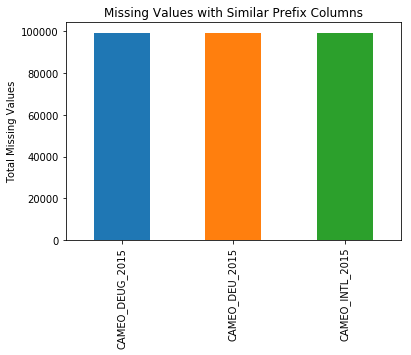

In [18]:
# Investigating columns with similar prefixes

cameo_cols = (azdias.loc[:, azdias.columns.str.startswith('CAMEO')]).isna().sum()
cameo_cols.plot(kind='bar')
plt.title('Missing Values with Similar Prefix Columns')
plt.ylabel('Total Missing Values');

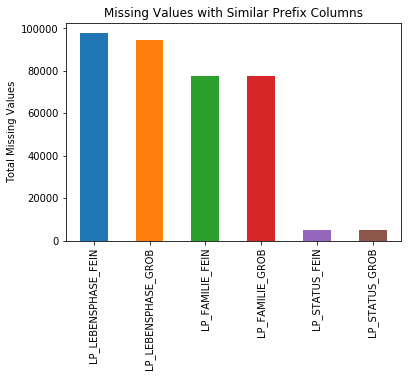

In [19]:
# Investigating columns with similar prefixes

lp_cols = (azdias.loc[:, azdias.columns.str.startswith('LP')]).isna().sum()
lp_cols.plot(kind='bar')
plt.title('Missing Values with Similar Prefix Columns')
plt.ylabel('Total Missing Values');

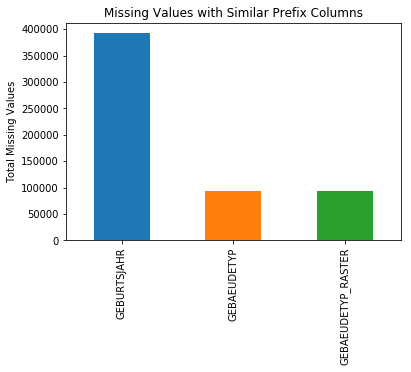

In [20]:
# Investigating columns with similar prefixes

geb_cols = (azdias.loc[:, azdias.columns.str.startswith('GEB')]).isna().sum()
geb_cols.plot(kind='bar')
plt.title('Missing Values with Similar Prefix Columns')
plt.ylabel('Total Missing Values');

In [21]:
# Removing any outlier columns in the dataset

drop_columns = list(azdias.columns[azdias.isna().sum()>200000])
for value in drop_columns:
    azdias.drop(value, axis = 1, inplace = True)

In [22]:
# Checking if columns were dropped

azdias.shape[1]

79

#### Discussion 1.1.2: Assess Missing Data in Each Column

    Most of the columns within the dataset are in the range of having 0-20% of their data missing. Twenty-four columns had zero missing data, and six columns had 30-100% of their data missing. These six columns were the outliers in terms of missing data, so they were removed. The names of the six columns removed are: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH. There were so many missing values within these columns, that the columns will not be very helpful in terms of data. Patterns were explored throughout this dataset in terms of missing values. I investigated columns with the same prefixes and discovered that most columns with the same prefixes are more likely to have the exact amount of missing data. However, there were some exceptions.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# Displaying how much data is missing in each row of the dataset by index

missing_rdata = azdias.isna().sum(axis=1).sort_values(ascending=False)
missing_rdata

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

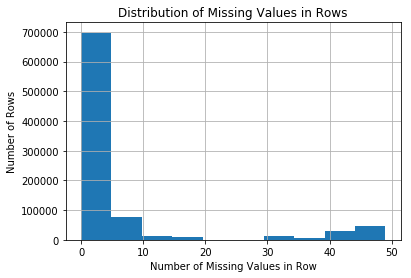

In [24]:
# Displaying the distribution of rows with missing values

missing_rdata.hist()
plt.title('Distribution of Missing Values in Rows')
plt.xlabel('Number of Missing Values in Row')
plt.ylabel('Number of Rows');

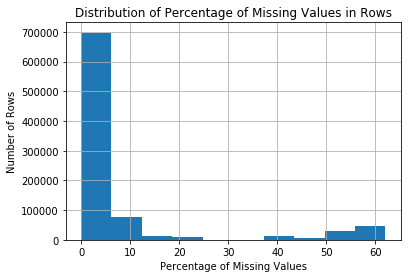

In [25]:
# Graphing percentage of missing values in rows

percentage_rmissing = (azdias.isna().sum(axis=1) / azdias.shape[1]) * 100

percentage_rmissing.hist()
plt.title('Distribution of Percentage of Missing Values in Rows')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Rows');

In [26]:
# Selecting rows above or equal to the selected threshold of 25 missing values per row

above_thres = azdias[azdias.isna().sum(axis=1)>=25]

In [27]:
# Selecting rows below the selected threshold of 25 missing values per row

below_thres = azdias[azdias.isna().sum(axis=1)<25]

In [28]:
# Selection of five columns with no missing data

values = azdias.isna().sum().sort_values(ascending=True).head(5)
five_columns = values.index.tolist()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


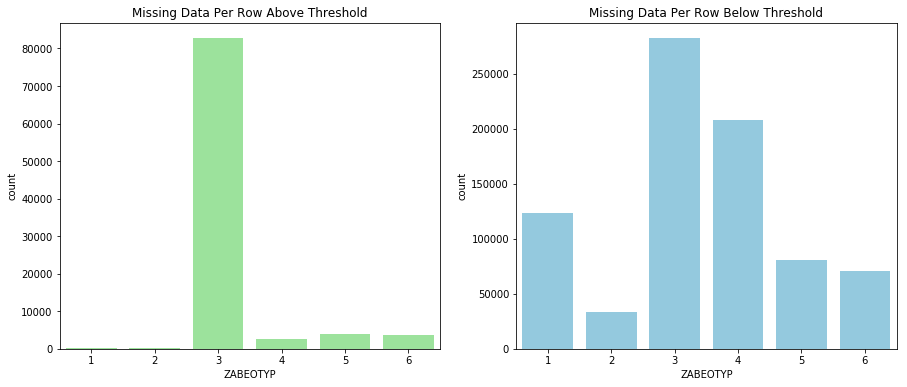

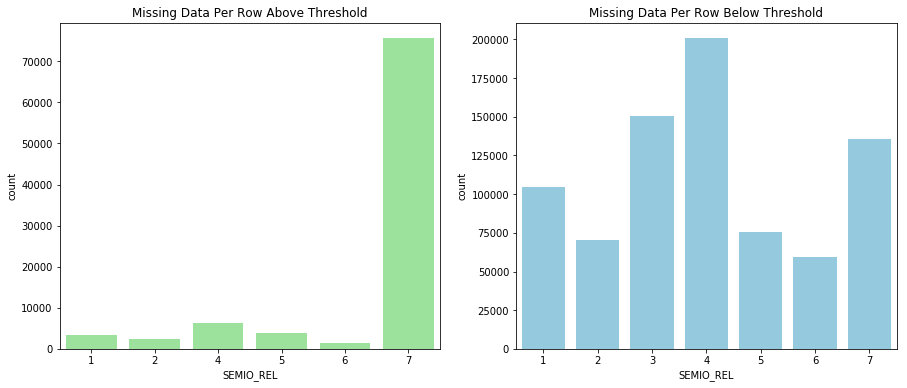

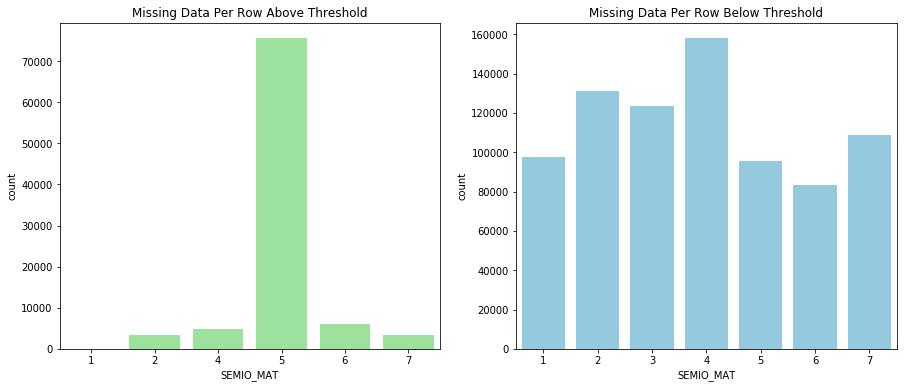

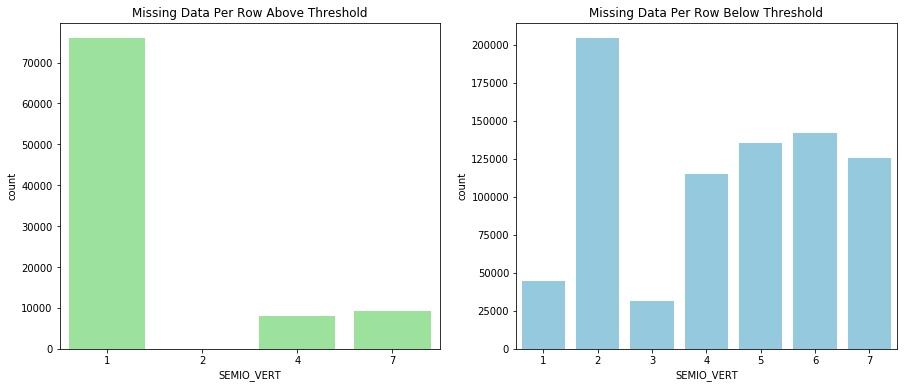

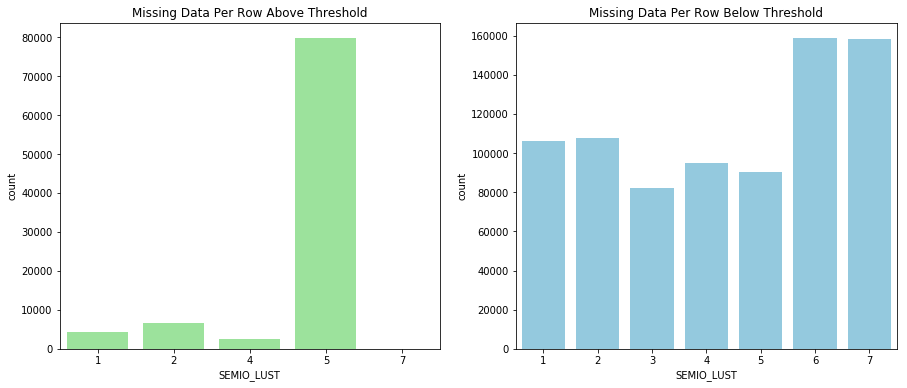

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_threshold(column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6))
    sns.countplot(data=above_thres, x = column, color = 'lightgreen', ax = ax1).set(title='Missing Data Per Row Above Threshold')
    sns.countplot(data=below_thres, x = column, color = 'skyblue', ax = ax2).set(title='Missing Data Per Row Below Threshold')
    fig.show();
for column in five_columns:
    compare_threshold(column)

#### Discussion 1.1.3: Assess Missing Data in Each Row
    The distribution of rows with missing values lies mainly within the 0-10 range, with almost 700,000 rows. However, some rows had over 60 missing values. I divided the subsets based on the threshold of a row having either over or equal to 25 values missing in a row and based on having under 25 values missing in a row. I would say the data with lots of missing values are qualitatively different from data with little to no missing values, enough to make a difference in the analysis later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?

feat_info = feat_info[~feat_info['attribute'].isin(drop_columns)]
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_vars = feat_info[feat_info['type'] == 'categorical']
categorical_columns = categorical_vars['attribute'].tolist()
binary_columns = []
multi_columns = []

for column in categorical_columns:
    if (below_thres[column].nunique() == 2):
        binary_columns.append(column)
    elif (below_thres[column].nunique() >= 3):
        multi_columns.append(column)

In [32]:
# Finding column to re-encode

re_encoded = []
for column in binary_columns:
    if np.dtype(below_thres[column]) == object:
        re_encoded.append(column)
print('Column to re-encode:',re_encoded[0])
print('Re-encode column unique values:',below_thres[re_encoded[0]].unique())

Column to re-encode: OST_WEST_KZ
Re-encode column unique values: ['W' 'O']


In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.

below_thres['OST_WEST_KZ'] = np.where(below_thres['OST_WEST_KZ'] == 'W', 1, 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
# Checking that object variables were changed to numeric

print('Re-encoded column unique values as numbers:',below_thres['OST_WEST_KZ'].unique())

Re-encoded column unique values as numbers: [1 0]


In [35]:
# Dropping multi-level categoricals

for value in multi_columns:
    below_thres.drop(value, axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.1: Re-Encode Categorical Features
    Throughout my wrangling of categorical features, I decided to store in a list and keep the binary variable features. The one non-numeric binary column, I replaced the two values with 0 and 1. I also decided to drop the multi-level categorical features to simplify the dataset to make it easier to work with. I sorted the binary and multi-level features with a loop into two separate lists to make it easier to work with. Then I changed the variables in the column OST_WEST_KZ to be numeric like all of the other binary columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
# Creating list of mixed type features

mixed_vars = feat_info[feat_info['type'] == 'mixed']
mixed_columns = mixed_vars['attribute'].tolist()

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

below_thres['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Movements Binary: 0 = Mainstream, 1 = Avantegarde

movements = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
decades = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

# Creating new columns with new variables
below_thres['Movement'] = below_thres['PRAEGENDE_JUGENDJAHRE']
below_thres['Decade'] = below_thres['PRAEGENDE_JUGENDJAHRE']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
# Adding new replacement variables into new columns

below_thres['Movement'] = below_thres['Movement'].map(movements)
below_thres['Decade'] = below_thres['Decade'].map(decades)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [40]:
# Checking that the variables were changed

below_thres['Movement'].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: Movement, dtype: float64

In [41]:
# Checking that the variables were changed

below_thres['Decade'].head()

1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
Name: Decade, dtype: float64

In [42]:
# Dropping 'PRAEGENDE_JUGENDJAHRE' column in dataset and column list

below_thres.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
mixed_columns.remove('PRAEGENDE_JUGENDJAHRE')

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

below_thres['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [44]:
# Creating lists of two new variables

wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
          '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
          '51':5, '52':5, '53':5, '54':5, '55':5}
life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
          '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
          '51':1, '52':2, '53':3, '54':4, '55':5}

# Creating new columns with new variables
below_thres['Wealth'] = below_thres['CAMEO_INTL_2015']
below_thres['Life_Stage'] = below_thres['CAMEO_INTL_2015']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [45]:
# Adding new replacement variables into new columns

below_thres['Wealth'] = below_thres['Wealth'].map(wealth)
below_thres['Life_Stage'] = below_thres['Life_Stage'].map(life_stage)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [46]:
# Checking that the variables were changed

below_thres['Wealth'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: Wealth, dtype: float64

In [47]:
# Checking that the variables were changed

below_thres['Life_Stage'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: Life_Stage, dtype: float64

In [48]:
# Dropping 'CAMEO_INTL_2015' column in dataset and column list

below_thres.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
mixed_columns.remove('CAMEO_INTL_2015')

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.2.2: Engineer Mixed-Type Features
    I organized the mixed-type features into ordinal values in the columns 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'. Two new columns came out of the 'PRAEGENDE_JUGENDJAHRE' column, one that I made binary with 0's and 1's and another that represented the decade with numeric values. Two new columns were also made with the 'CAMEO_INTL_2015' column data, a wealth column that was ordinal based on the ten's place of the value and a life stage column that was ordinal based on the one's place of the value. Both columns were then dropped, since their data is not necessary anymore.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [49]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [50]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Removing mixed-type columns that were not re-engineered
for value in mixed_columns:
    below_thres.drop(value, axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [51]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # convert missing codes to NaN
    all_missing_values = []

    for lis in feat_info['missing_or_unknown']:
        missing_values = []
        lis = lis.strip('[')
        lis = lis.strip(']')
        lis = lis.split(',')
        if lis != ['']:
            for value in lis:
                if value != 'X' and value != 'XX':
                    missing_values.append(int(value))
                else:
                    missing_values.append(value)
        else:
            missing_values.append('')
        all_missing_values.append(missing_values)

    feat_info['na_values'] = all_missing_values
    new_feat_info = feat_info.set_index('attribute')

    for (index, attribute) in enumerate(df):
        df[attribute].replace(feat_info.iloc[index-1].loc['na_values'], np.nan, inplace = True)

    # remove selected columns and rows, ...
    
    # removing any outlier columns in the dataset
    drop_columns = list(df.columns[df.isna().sum()>200000])
    for value in drop_columns:
        df.drop(value, axis = 1, inplace = True)
    feat_info = feat_info[~feat_info['attribute'].isin(drop_columns)]
        
    # removing rows below the selected threshold of 25 missing values per row
    below_thres_df = df[df.isna().sum(axis=1)<25]
    
    # select, re-encode, and engineer column values.
    
    # categorical values
    categorical_vars = feat_info[feat_info['type'] == 'categorical']
    categorical_columns = categorical_vars['attribute'].tolist()
    binary_columns = []
    multi_columns = []

    for column in categorical_columns:
        if (below_thres_df[column].nunique() == 2):
            binary_columns.append(column)
        elif (below_thres_df[column].nunique() >= 3):
            multi_columns.append(column)
            
    # finding column to re-encode
    re_encoded = []
    for column in binary_columns:
        if np.dtype(below_thres_df[column]) == object:
            re_encoded.append(column)
    below_thres_df['OST_WEST_KZ'] = np.where(below_thres_df['OST_WEST_KZ'] == 'W', 1, 0)
    
    # dropping multi-level categoricals
    for value in multi_columns:
        below_thres_df.drop(value, axis = 1, inplace = True)
    
    # mixed-type values

    mixed_vars = feat_info[feat_info['type'] == 'mixed']
    mixed_columns = mixed_vars['attribute'].tolist()
    
    movements = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    decades = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
              '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
              '51':5, '52':5, '53':5, '54':5, '55':5}
    life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
              '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
              '51':1, '52':2, '53':3, '54':4, '55':5}

    # creating new columns with new variables
    below_thres_df['Movement'] = below_thres_df['PRAEGENDE_JUGENDJAHRE']
    below_thres_df['Decade'] = below_thres_df['PRAEGENDE_JUGENDJAHRE']
    below_thres_df['Wealth'] = below_thres_df['CAMEO_INTL_2015']
    below_thres_df['Life_Stage'] = below_thres_df['CAMEO_INTL_2015']
    
    # adding new replacement variables into new columns
    below_thres_df['Movement'] = below_thres_df['Movement'].map(movements)
    below_thres_df['Decade'] = below_thres_df['Decade'].map(decades)
    below_thres_df['Wealth'] = below_thres_df['Wealth'].map(wealth)
    below_thres_df['Life_Stage'] = below_thres_df['Life_Stage'].map(life_stage)
    
    # dropping re-engineered columns
    below_thres_df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    mixed_columns.remove('PRAEGENDE_JUGENDJAHRE')
    below_thres_df.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
    mixed_columns.remove('CAMEO_INTL_2015')

    # Removing mixed-type columns that were not re-engineered
    for value in mixed_columns:
        below_thres_df.drop(value, axis = 1, inplace = True)

    # Return the cleaned dataframe.
    return below_thres_df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [52]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

na_number = below_thres.isna().sum().sum()
total_values = below_thres.shape[0]
print('Number of NaN values:', na_number, '\nNumber of total values:', total_values)

Number of NaN values: 760310 
Number of total values: 797906


In [53]:
# Applying Imputer to replace all missing values
from sklearn.preprocessing import Imputer

def data_imputer(df):
    data_columns = df.columns.tolist()
    imputer = Imputer()
    imp_dataset = imputer.fit_transform(df)
    imp_dataset = pd.DataFrame(imp_dataset, columns = data_columns)
    return imp_dataset

# Create dataset
imp_dataset = data_imputer(below_thres)

# Check dataset_was created
imp_dataset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Movement,Decade,Wealth,Life_Stage
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,90.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,1.0,90.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,0.0,70.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,0.0,70.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,50.0,5.0,4.0


In [54]:
# Check that all NaN values were inputed

imp_dataset.isna().sum().sum()

0

In [55]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
  
# Create dataset
data_columns = imp_dataset.columns.tolist()
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(imp_dataset)
scaled_dataset = pd.DataFrame(scaled_dataset, columns = data_columns)
    
# Check dataset_was created
scaled_dataset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Movement,Decade,Wealth,Life_Stage
0,-1.766002,0.957932,-1.494563,1.537958,-1.040677,1.466028,0.958855,1.339191,-0.530442,1.085862,...,0.419874,1.445427,0.565054,-0.167351,-0.127761,0.684563,-0.553143,1.165639,1.191195,-1.266339
1,0.201254,0.957932,-1.494563,0.864598,-1.766947,-0.570971,0.244297,1.339191,1.885219,1.085862,...,-0.975825,0.403437,0.565054,-0.167351,-0.127761,-0.789351,1.875298,1.165639,-0.865173,0.761924
2,1.184882,0.957932,0.683201,-0.482123,1.138132,-0.570971,-1.184817,-0.791446,-0.530442,-0.269876,...,-0.975825,-0.638553,0.565054,-1.170955,-0.998321,-0.052394,-0.553143,-0.231990,-1.550630,-0.590251
3,0.201254,-1.043916,0.683201,0.191237,0.411863,-1.249970,0.244297,-0.791446,-0.530442,1.085862,...,0.419874,-0.638553,-0.347923,0.836254,0.307519,1.421519,-0.553143,-0.231990,0.505739,0.085836
4,-1.766002,0.957932,-0.042721,-1.155483,1.138132,-0.570971,-0.470260,1.339191,-0.530442,1.085862,...,0.419874,1.445427,1.478031,-1.170955,-0.998321,-0.052394,-0.553143,-1.629618,1.191195,0.761924


### Discussion 2.1: Apply Feature Scaling
    With 760,310 NaN values in the dataset out of 797,906 total values, I decided to use sklearn's Imputer which set any NaN values to the column's average. If I were to delete the NaN data, the final dataset would be missing too much data to be useful. I then used Standard Scaler on the dataset without any NaN values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [56]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pca.fit_transform(scaled_dataset)

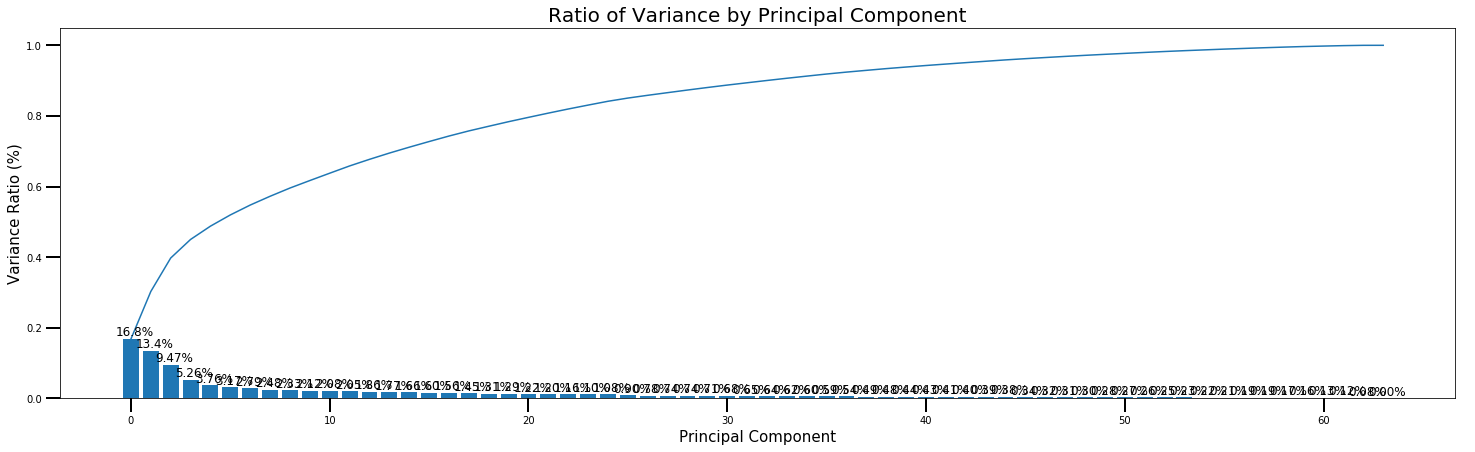

In [57]:
# Investigate the variance accounted for by each principal component.

pca_data = PCA().fit_transform(scaled_dataset)
num_components = len(pca.explained_variance_ratio_)
index = np.arange(num_components)
values = pca.explained_variance_ratio_
total_values = np.cumsum(values)

# Creating plot
plt.figure(figsize=(25,15))
axes = plt.subplot(211)
axes.bar(index, values)
axes.plot(index, total_values)
for i in range(num_components):
        axes.annotate(r"%s%%" % ((str(values[i]*100)[:4])), (index[i]+0.2, values[i]), va="bottom", ha="center", fontsize=12)

# Creating plot titles
plt.title('Ratio of Variance by Principal Component', fontsize=20)
plt.xlabel('Principal Component', fontsize=15)
plt.ylabel('Variance Ratio (%)', fontsize=15)
plt.tick_params(axis = 'both', width = 2, length = 14);

In [58]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_comp = PCA(n_components = 30)
pca_comp_data = pca_comp.fit_transform(scaled_dataset)

### Discussion 2.2: Perform Dimensionality Reduction
     PCA is a form of transformation for a dataset. PCA finds the direction of the highest variance in a dataset. I selected the number of components to retain to be 30, because as shown in the graph, it collected over 80% variability of the original variability.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [59]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def map_weights(df, pca, i):
    data_columns = below_thres.columns.tolist()
    feature_weights = pca.components_
    mapped_data = pd.DataFrame(feature_weights, columns = data_columns).iloc[i]
    mapped_data = mapped_data.sort_values(ascending = False)
    return mapped_data

# Displaying sorted list of feature weights for first principal component
map_weights(pca_comp_data, pca, 0).head()

PLZ8_ANTG3            0.227751
PLZ8_ANTG4            0.220936
Wealth                0.208190
HH_EINKOMMEN_SCORE    0.204420
ORTSGR_KLS9           0.198451
Name: 0, dtype: float64

In [60]:
map_weights(pca_comp_data, pca, 0).tail()

KBA05_GBZ           -0.218189
FINANZ_MINIMALIST   -0.218342
KBA05_ANTG1         -0.226661
PLZ8_ANTG1          -0.227403
MOBI_REGIO          -0.243173
Name: 0, dtype: float64

In [61]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(pca_comp_data, pca, 1).head()

ALTERSKATEGORIE_GROB    0.261394
FINANZ_VORSORGER        0.234436
SEMIO_ERL               0.231106
SEMIO_LUST              0.184343
RETOURTYP_BK_S          0.163817
Name: 1, dtype: float64

In [62]:
map_weights(pca_comp_data, pca, 1).tail()

SEMIO_PFLICHT   -0.229047
SEMIO_TRADV     -0.232324
FINANZ_SPARER   -0.237586
Decade          -0.252526
SEMIO_REL       -0.255669
Name: 1, dtype: float64

In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(pca_comp_data, pca, 2).head()

SEMIO_VERT           0.345260
SEMIO_SOZ            0.262520
SEMIO_FAM            0.250184
SEMIO_KULT           0.235625
FINANZ_MINIMALIST    0.155894
Name: 2, dtype: float64

In [64]:
map_weights(pca_comp_data, pca, 2).tail()

SEMIO_RAT    -0.217508
SEMIO_KRIT   -0.276149
SEMIO_DOM    -0.314324
SEMIO_KAEM   -0.337106
ANREDE_KZ    -0.368739
Name: 2, dtype: float64

### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 7.3. MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### 1.20. SEMIO_VERT, SEMIO_REL
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded

### 1.3. ANREDE_KZ
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

### Discussion 2.3: Interpret Principal Components
    The feature 'PLZ8_ANTG3' was the highest in terms of positive value for the first principal component, while 'MOBI_REGIO' was the highest in terms of negative value. The relationship between these two features is movement patterns based on number of 6-10 family houses in a region. The feature 'ALTERSKATEGORIE_GROB' was the highest positive value for the second principal component and 'SEMIO_REL' was the highest negative value. Their relationship is based on estimated age based on given name to personality typology. The third principal component had the highest positive value feature as 'SEMIO_VERT' and the highest negative value feature as 'ANREDE_KZ'. The relationship between these two features is personality typology based on gender. Meaningful interpretation can be taken from these values, since their relationships values are similar and could effect one or another.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [65]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

def find_clusters(df):
    cluster_counts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    score_list = []

    # run k-means clustering on the data and...
    for count in cluster_counts:
        kmeans = KMeans(count)
        model = kmeans.fit(df)
        labels = model.predict(df)

    # compute the average within-cluster distances.
        score_list.append(abs(model.score(df)))
        print('Cluster:', count, 'Average:', abs(model.score(df)))

    return score_list

In [66]:
# Investigate the change in within-cluster distance across number of clusters.

score_list = find_clusters(pca_comp_data) #[44956509.997186512, 38505511.767147809, 35230185.200978287, 33130872.402717657, 31657304.518611547, 30433965.785671405, 29280948.161372703, 28417388.308067638, 27823956.454643417, 27369270.047428757, 26626503.996621251, 26416212.3733]
cluster_counts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

plt.plot(cluster_counts, score_list, marker='o')
plt.title('Average Value Distances from Center of Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Average Cluster Distance');

"\nscore_list = find_clusters(pca_comp_data) #[44956509.997186512, 38505511.767147809, 35230185.200978287, 33130872.402717657, 31657304.518611547, 30433965.785671405, 29280948.161372703, 28417388.308067638, 27823956.454643417, 27369270.047428757, 26626503.996621251, 26416212.3733]\ncluster_counts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]\n\nplt.plot(cluster_counts, score_list, marker='o')\nplt.title('Average Value Distances from Center of Cluster')\nplt.xlabel('Cluster Number')\nplt.ylabel('Average Cluster Distance');"

In [76]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(10)
model = kmeans.fit(pca_comp_data)
azdias_cluster_predictions = model.predict(pca_comp_data)

### Discussion 3.1: Apply Clustering to General Population
    I tested a total of 12 clusters with the dataset and I plotted the average distance from each cluster's center. Because of the results displayed in the plot, I decided to segment the population into 10 clusters because the 10 mark seems to be where the data starts to steady into a line. The 10 line mark appears to be the elbow in the graph.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.

customers_data = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers_data.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Cleaning customer data with cleaning function
clean_customer_data = clean_data(customers_data, feat_info)

# Imputing and scaling customer data
imputed_customer_data = data_imputer(clean_customer_data)

# Scaling Customer Data
data_columns = imputed_customer_data.columns.tolist()
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(imputed_customer_data)
scaled_customer_data = pd.DataFrame(scaled_dataset, columns = data_columns)

# Applying PCA
pca = PCA()
pca_customer_data = pca.fit_transform(scaled_customer_data)

# Fitting customer data with cluster predictions
cluster = 10
kmeans = KMeans(cluster)
model = kmeans.fit(pca_customer_data)
customer_cluster_predict = model.predict(pca_customer_data)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-p

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

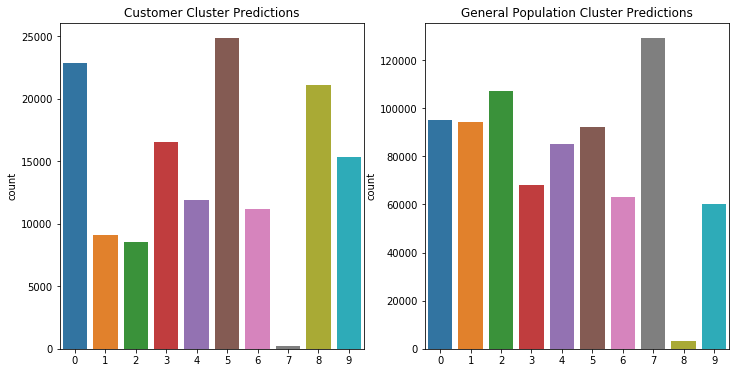

In [70]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
sns.countplot(customer_cluster_predict, ax = ax1).set(title='Customer Cluster Predictions')
sns.countplot(azdias_cluster_predictions, ax = ax2).set(title='General Population Cluster Predictions');

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# 1
overrep = scaler.inverse_transform(pca_comp.inverse_transform(model.cluster_centers_[1]))

ValueError: operands could not be broadcast together with shapes (64,) (66,) (64,) 

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# 5

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)